In [1]:
!kaggle datasets download -d aryashah2k/mango-leaf-disease-dataset -p /content/mango_leaf_disease --unzip


Dataset URL: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 78% 81.0M/103M [00:01<00:00, 93.2MB/s]
100% 103M/103M [00:01<00:00, 100MB/s]  


In [2]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [3]:
base_dir = '/content/mango_leaf_disease'

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3200 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [5]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 532ms/step - accuracy: 0.2517 - loss: 2.0944 - val_accuracy: 0.5200 - val_loss: 1.7161 - learning_rate: 1.0000e-05
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 518ms/step - accuracy: 0.5843 - loss: 1.2076 - val_accuracy: 0.7475 - val_loss: 1.1631 - learning_rate: 1.0000e-05
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 527ms/step - accuracy: 0.7799 - loss: 0.6809 - val_accuracy: 0.8350 - val_loss: 0.7267 - learning_rate: 1.0000e-05
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 519ms/step - accuracy: 0.8742 - loss: 0.4301 - val_accuracy: 0.8712 - val_loss: 0.4721 - learning_rate: 1.0000e-05
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 526ms/step - accuracy: 0.9081 - loss: 0.3202 - val_accuracy: 0.8700 - val_loss: 0.3810 - learning_rate: 1.0000e-05
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 522ms/step - accuracy: 0.9236 - loss: 0.2607 - val_accuracy: 0.9075 - val_loss: 0.3032 - learning_rate: 1.0000e-05
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 52

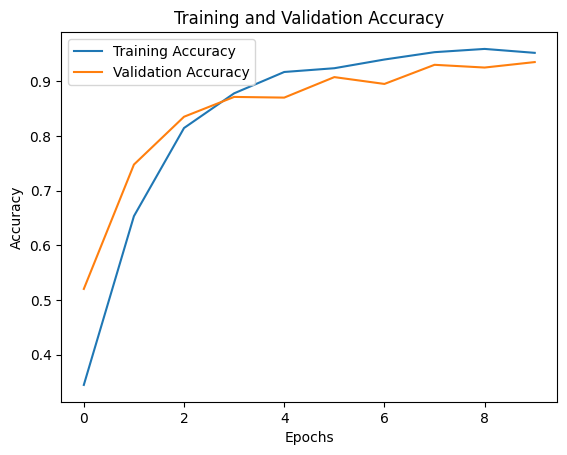

In [8]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='upper left')
plt.show()